# Ground Truth

## Overview

In this study, we investigate the potential of Sentinel-2 Level-2A data for classifying evergreen leafs of forests in temperate climates. We begin with processing the ground truth data before performing any experiments.

In this Jupyter Notebook we inspect the ground truth data and generate the target rasters.

## How To Run

Please refer to the REAMDE.md file in this repository for a tutorial on how to set up [GEE](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api). Additionally you need a dataset of CSV files in `../data/interim/train/` as well as in `../data/interim/test/`. These CSV files should contain following columns:
```python
"genus": str  # Tree genus
"date": str  # Date in YYYY-MM-DD format
"dbh": 0 < float  # DBH in meters
"latitude": float
"longitude": float
```
You can use the dataset inside the `train` folder but need to provide your own `test` dataset. Then you can run the notebook using Run All in your IDE.

## Target Preprocessing

The target rasters in the `train` folder are computed from representation areas for bavarian natural forest reserves. The target raster used as `test` set is computed from the [25 ha Traunstein Forest Dynamics Plot](https://forestgeo.si.edu/sites/europe/traunstein). You can request the dataset [here](http://ctfs.si.edu/datarequest/index.php/request/form/31) and follow above CSV format to generate the target raster.

We load the train set and filter it by date:

In [1]:
# Load the data and convert it to a GeoDataFrame
from logging import INFO
from pathlib import Path
from sys import stdout

import geopandas as gpd
import pandas as pd
from loguru import logger

logger.configure(handlers=[{"sink": stdout, "format": "{message}", "level": INFO}])

example_path = Path("../data/interim/train/95.csv")
example = pd.read_csv(example_path, parse_dates=["date"])

data = example.drop(["longitude", "latitude"], axis=1)
geometry = gpd.points_from_xy(example["longitude"], example["latitude"])
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326", geometry=geometry)

gdf = gdf.to_crs("EPSG:32633")

logger.info("Data types per column:\n")
logger.info(gdf.dtypes)

Data types per column:

genus               object
date        datetime64[ns]
dbh                float64
geometry          geometry
dtype: object


  0%|          | 0/90 [00:00<?, ?it/s]

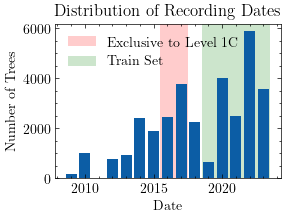

In [2]:
# Plot the distribution of the recording dates
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots  # noqa: F401
from tqdm.notebook import tqdm

from slc.visualize import save_fig

plt.style.use("science")

csv_paths = list(Path("../data/interim/train/").glob("*.csv"))
dates = []
for path in tqdm(csv_paths):
    area = pd.read_csv(path, parse_dates=["date"])
    dates.extend(area["date"])

fig, ax = plt.subplots(figsize=(5.81 / 2, 2))
series = pd.Series(dates).dt.year.value_counts()
series = series.reindex(range(series.index.min(), series.index.max() + 1), fill_value=0)
plt.bar(series.index, series.values)

ax.set_title("Distribution of Recording Dates")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Trees")

y_lim = ax.get_ylim()
ax.set_ylim(y_lim)
ax.fill_betweenx(
    y_lim,
    2015.5,
    2017.5,
    color="red",
    alpha=0.2,
    zorder=0,
    linewidth=0,
    label="Exclusive to Level 1C",
)
ax.fill_betweenx(
    y_lim,
    2018.5,
    series.index.max() + 0.5,
    color="green",
    alpha=0.2,
    zorder=0,
    linewidth=0,
    label="Train Set",
)
ax.legend(loc="upper left")

As we use Sentinel-2 Level-2A data for our study, the first year covered completely by satellite data is [2018](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED). We filter the data to only include data collected from 2019 onwards, as we want the satellite imagery from the year the data was collected and the year 2018 is reserved for the test set. This does reduce the dataset significantly but ensures high quality data for our study and the ability to demonstrate the ability to generalize across time. Additionally, we exclude all study areas with data spanning multiple years and convert the remaining areas to rasters using the Google Earth Engine API.

We prefer using the [Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A]((https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED)) dataset, as it is atmospherically corrected and harmonized, shifting data in newer scenes to a range comparable to older scenes. The Level-1C data would allow us to use more data, by incorporating the study areas with sample dates from 2016 onwards, but would lower the quality of the Sentinel-2 data.

The plot data is converted to a raster with a resolution of 10 meters and the appropriate UTM coordinate reference system projection as the Sentinel-2 data. See [Sentinel-2 User Handbook](https://sentinel.esa.int/documents/247904/685211/Sentinel-2_User_Handbook) page 9 and 36. The resulting target rasters contain the base area per genus as channels:

In [3]:
# Convert the data to two rasters
import rasterio

from slc.data import compute_target

FIRST_YEAR = 2019

gt_path = Path("../data/processed/")
gt_path.mkdir(parents=True, exist_ok=True)

total = 0
target_paths = []
for path in tqdm(csv_paths):
    area = pd.read_csv(path, parse_dates=["date"])

    if len(area) == 0:
        logger.debug(f"Skipping {path} as it is empty")
        continue

    if area.isna().any(axis=None):
        logger.debug(f"Skipping {path} as it contains missing values")
        continue

    dates = area["date"].unique()
    if len(dates) > 1:
        logger.debug(f"Skipping {path} as data was collected in multiple years")
        continue

    year = dates[0].year
    if year < FIRST_YEAR:
        logger.debug(
            f"Skipping {path} as data was collected in {year}. Level-2A data covers all years fully starting at {FIRST_YEAR}."
        )
        continue

    total += len(area)

    area_id = Path(path).stem
    target_path = gt_path / f"target/{area_id}_{year}.tif"
    if not target_path.exists():
        target_path.parent.mkdir(parents=True, exist_ok=True)
        compute_target(target_path=target_path, plot=area)

    target_paths.append(target_path)

total_area = 0
for target_path in target_paths:
    with rasterio.open(target_path) as target:
        total_area += target.dataset_mask().astype(bool).sum()

logger.info(f"Total number of trees: {total}")
logger.info(f"Number of target rasters: {len(target_paths)}")
logger.info(f"Total area: {total_area * 100 / 10_000} hectares")

  0%|          | 0/90 [00:00<?, ?it/s]

Total number of trees: 16162
Number of target rasters: 48
Total area: 49.12 hectares


After selecting the areas, our dataset consists of 16162 trees distributed over 48 areas. To visualize the conversion to raster format, we plot the tree level data of the CSV file and a processed version of the raster data:

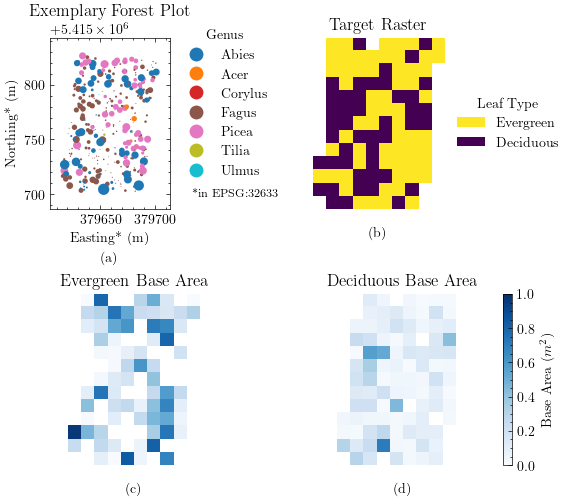

In [4]:
# Plot the data on stem level, the final raster, and plot the base area separately per leaf type
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import rasterio
from matplotlib.cm import ScalarMappable, viridis
from matplotlib.patches import Patch

from slc.features import genera2target, load_raster
from slc.visualize import label_subplots

gdf_buffer = gdf.copy()
gdf_buffer["geometry"] = gdf_buffer["geometry"].buffer(gdf_buffer["dbh"] * 5)

# Plot
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(5.81, 5), constrained_layout=True)
ax = axs[0, 0]
golden_ratio = (1 + 5**0.5) / 2
ax = gdf_buffer.plot(
    column="genus",
    legend=True,
    legend_kwds={
        "title": "Genus",
        "loc": "center left",
        "bbox_to_anchor": (1, 1 / golden_ratio),
    },
    ax=ax,
)

ax.margins(x=0.1, y=0.1)

# Format
ax.set_title("Exemplary Forest Plot")
ax.set_xlabel("Easting* (m)")
ax.set_ylabel("Northing* (m)")
annotation_x = ax.get_position().x1 + 0.05
annotation_y = ax.get_position().y0 + 0.09
fig.text(
    annotation_x,
    annotation_y,
    "*in EPSG:32633",
    ha="center",
    va="top",
    fontsize="small",
    transform=fig.transFigure,
)

year = pd.read_csv(example_path, parse_dates=["date"])["date"].dt.year.unique()[0]
raster_path = gt_path / "target" / f"{example_path.stem}_{year}.tif"
example_raster = load_raster(raster_path)
example_classification = genera2target(example_raster)
example_regression = genera2target(example_raster, regression=True)

with rasterio.open(raster_path) as src:
    shape = src.shape

# Plot the conifer content
target = example_classification.map({"deciduous": 0, "evergreen": 1}).astype(float)
target = target.to_numpy().reshape(shape)
shape = target.shape

ax = axs[0, 1]
img = ax.imshow(target, interpolation="nearest")
ax.set_title("Target Raster")
ax.axis("off")

ax.legend(
    handles=[
        Patch(facecolor=viridis.get_over(), label="Evergreen"),
        Patch(facecolor=viridis.get_under(), label="Deciduous"),
    ],
    title="Leaf Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

# Plot the evergreen area
evergreen_area = example_regression["evergreen"].to_numpy().reshape(shape)
evergreen_area[evergreen_area == 0] = np.nan

norm = plt.Normalize(vmin=0, vmax=1)
ax = axs[1, 0]
img = ax.imshow(evergreen_area, cmap="Blues", norm=norm, interpolation="nearest")
ax.set_title("Evergreen Base Area")
ax.set(xticks=[], yticks=[])
ax.spines[["top", "right", "left", "bottom"]].set_visible(False)

# Plot the broadleaf area
deciduous_area = example_regression["deciduous"].to_numpy().reshape(shape)
deciduous_area[deciduous_area == 0] = np.nan

ax = axs[1, 1]
img = ax.imshow(deciduous_area, cmap="Blues", norm=norm, interpolation="nearest")
ax.set_title("Deciduous Base Area")
ax.set(xticks=[], yticks=[])
ax.spines[["top", "right", "left", "bottom"]].set_visible(False)

mappable = ScalarMappable(norm=norm, cmap="Blues")
fig.colorbar(mappable, ax=axs[1, :], label="Base Area ($m^2$)", pad=-0.15)

label_subplots(axs.flatten(), y_offset=[0.25, 0.1, 0.1, 0.1])

save_fig(fig, "../reports/figures/ground_truth/Evergreen Class Computation.pdf")

For classification we divide each genus into two classes: evergreen and deciduous. The base area per class is used to determine the dominant leaf class for each pixel. The resulting target rasters are stored in the `../data/processed/target` folder.

The dataset is biased towards deciduous trees, as they are more common in natural forest reserves in the temperate climate of Bavaria. To gain insights into the distribution of the different classes and genera, we plot the distribution of the classes and genera in the dataset. For a nuanced presentation we use a logarithmic scale for the second plot:

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

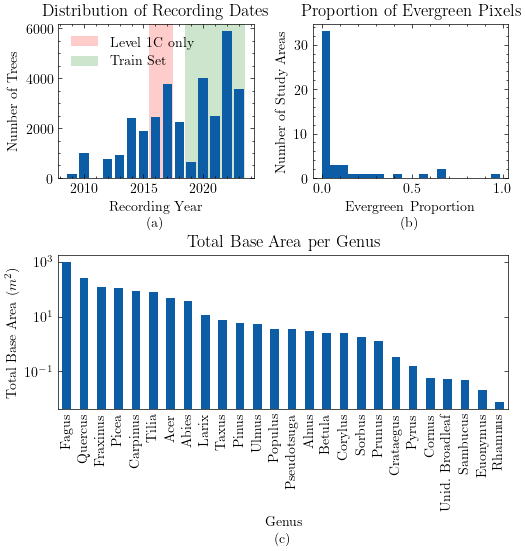

In [5]:
# Compute the proportion of evergreen pixels for every raster and plot it in a kde plot
import matplotlib.pylab as pl
from matplotlib import gridspec

from slc.features import genera2target, load_raster

gs = gridspec.GridSpec(2, 2, hspace=0.5, wspace=0.3)

fig = pl.figure(figsize=(5.81, 5))  # , constrained_layout=True)
ax = pl.subplot(gs[0, 0])  # row 0, col 0

ax.bar(series.index, series.values)

ax.set_title("Distribution of Recording Dates")
ax.set_xlabel("Recording Year")
ax.set_ylabel("Number of Trees")

y_lim = ax.get_ylim()
ax.set_ylim(y_lim)
ax.fill_betweenx(
    y_lim,
    2015.5,
    2017.5,
    color="red",
    alpha=0.2,
    zorder=0,
    linewidth=0,
    label="Level 1C only",
)
ax.fill_betweenx(
    y_lim,
    2018.5,
    series.index.max() + 0.5,
    color="green",
    alpha=0.2,
    zorder=0,
    linewidth=0,
    label="Train Set",
)
ax.legend(loc="upper left")

ax = pl.subplot(gs[0, 1])  # row 0, col 1

proportions = []
for path in tqdm(target_paths):
    raster = load_raster(path, monochrome_as_dataframe=True)
    classification = genera2target(raster)
    proportions.append(classification.map({"deciduous": 0, "evergreen": 1}).mean())

prop = pd.Series(proportions)
prop.hist(bins=20, ax=ax)
ax.set_title("Proportion of Evergreen Pixels")
ax.set_xlabel("Evergreen Proportion")
ax.set_ylabel("Number of Study Areas")
ax.grid(visible=False)

proportions = []
for path in tqdm(target_paths):
    raster = load_raster(path, monochrome_as_dataframe=True)
    proportions.append(raster)

proportions = pd.concat(proportions)
proportions = proportions.fillna(0)
proportions = proportions.rename(columns={"Unidentified broadleaf": "Unid. Broadleaf"})

ax = pl.subplot(gs[1, :])  # row 1, span all columns

proportions.sum(axis=0).sort_values(ascending=False).plot(kind="bar", logy=True, ax=ax)
ax.set_title("Total Base Area per Genus")
ax.set_xlabel("Genus")
ax.set_ylabel("Total Base Area ($m^2$)")
ax.tick_params(axis="x", which="both", length=0)

label_subplots(np.asarray(fig.axes), y_offset=[0.25, 0.25, 0.8])

save_fig(fig, "../reports/figures/ground_truth/Bar Plots.pdf")

The dataset is biased towards deciduous trees, with Fagus being the most prominent genus. This is expected, as the temperate climate of Bavaria would naturally favor deciduous trees. All four most common genera in Bavaria are present in the dataset. Those are [Picea, Pinus, Fagus, and Quercus](https://www.bmel.de/SharedDocs/Downloads/DE/Broschueren/waldzustandserhebung-2023.html).